# Creating a Grid of PSFs in WebbPSF with `psf_grid()`

In order to use photutils to do PSF-fitting photometry on simulated JWST PSFs, the first step is to create a grid of fiducial PSFs spanning the instrument/detector of choice. This can be done using the `psf_grid()` method in WebbPSF which will output a (list of or single) photutils `GriddedPSFModel` object(s). Users can then use photutils to apply interpolation to the grid to simulate a spatially dependent PSF anywhere on the instrument, without having to perform a full PSF calculation at each location. This faster approach is critical if you're dealing with potentially tens of thousands of stars scattered across many megapixels of detector real estate.

This notebook will describe how to use WebbPSF to create these grids of PSFs. 

See the [Photutils documentation](https://photutils.readthedocs.io/) for detailed instructions on how to use a `GriddedPSFModel`. We provide only basic examples here. 

<img src="example_psf_grid.png" width=350px>

<div class="alert alert-warning">Warning: This notebook creates many large GriddedPSFModel objects and will therefore take a long time to run. The examples iterating over all NIRCam detectors are particularly time consuming. We suggest only running one or two examples as the examples just show the different parameters available when creating the grid of PSFs.</div>

For those who have used WebbPSF before, `psf_grid()` is set up in a similar manner to `calc_psf()`. A basic use of this method looks like:

In [ ]:
from astropy.io import fits
import matplotlib
import webbpsf
from webbpsf.utils import to_griddedpsfmodel
print("Notebook tested with WebbPSF 0.8.1, currently running on WebbPSF", webbpsf.version.version)

In [3]:
# Create a 3x3 grid of PSFs for NIRCam
nrc = webbpsf.NIRCam()
nrc.filter = "F430M"
nrc_grid = nrc.psf_grid(num_psfs=9, all_detectors=False)


Running instrument: NIRCam, filter: F430M
  Running detector: NRCA5
    Position 1/9: (0, 0) pixels
    Position 2/9: (0, 1024) pixels
    Position 3/9: (0, 2047) pixels
    Position 4/9: (1024, 0) pixels
    Position 5/9: (1024, 1024) pixels
    Position 6/9: (1024, 2047) pixels
    Position 7/9: (2047, 0) pixels
    Position 8/9: (2047, 1024) pixels
    Position 9/9: (2047, 2047) pixels


There is a helper function `display_psf_grid` that lets you visualize the results of that calculation. 

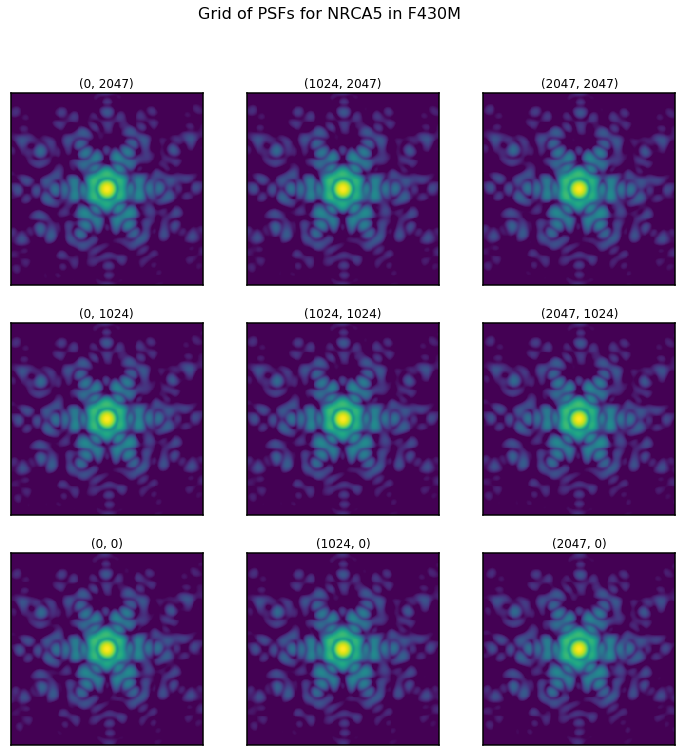

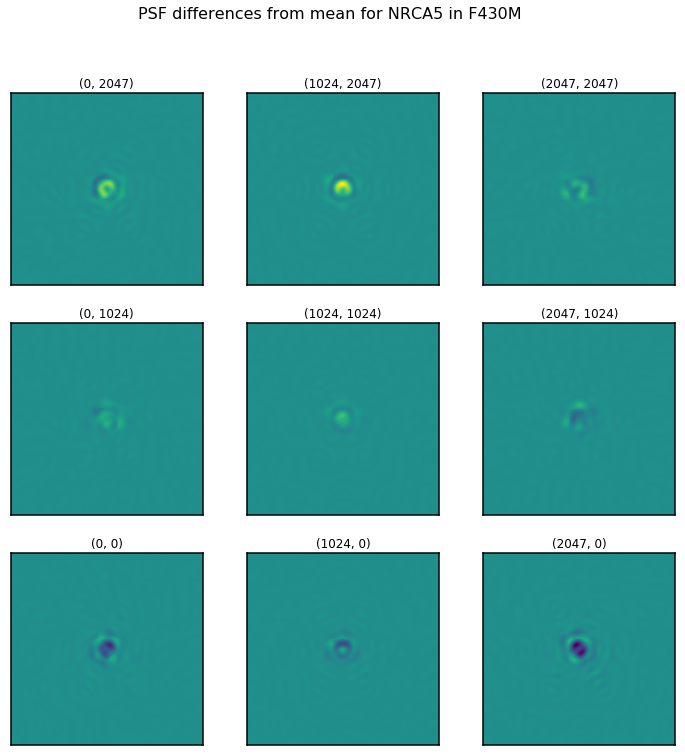

In [4]:
webbpsf.gridded_library.display_psf_grid(nrc_grid)

For instruments with multiple detectors, `psf_grid` will iterate over all of them by default. This can take significant time to run. (Note that in the above example, we set `all_detectors=False`  to avoid this).

Here is a 4x4 grid, iterated over all 8 SW detectors in NIRCam. Note that since it iterates over multiple detectors, what is returns is a list containing a grid for each detector. This will take a while:

In [ ]:
# Create a grid of PSFs for all detectors in NIRCam
nir = webbpsf.NIRCam()
nir.filter = "F090W"
list_of_grids = nir.psf_grid()

### Outputs

For each instrument/filter/detector combination, `psf_grid()` will return a a `GriddedPSFModel` object containing a 3D array of Z $\times$ n $\times$ n. The 3D array represents the Z number of 2D n $\times$ n PSFs created on the detector. You can check the `grid_xypos` key (or if you save the object as a `FITS` file, the `DET_YX#` header keywords) which will state the position of the PSF on the detector for each of the PSFs. The order of the tuples in `grid_xypos` (and the number in the `FITS` header keyword) refers to the number the PSF is in the 3D array.

If you set `all_detectors=True` and the instrument you chose has more than one detector (e.g. NIRCam), `psf_grid()` will return a list of 3D `GriddedPSFModel` objects, with one object per detector. If you defined only 1 detector, or have `all_detectors=True` when your instrument only has 1 detector (e.g. NIRISS), `psf_grid()` will return a single `GriddedPSFModel` object.

If you set `save=True`, the `GriddedPSFModel` will be saved as a `FITS` object. This can later be read in and converted back to a `GriddedPSFModel`. The method for how to do this will be detailed below.

### Summary of Input Parameters for PSF grid calculations


Many parameters for the calculation are set _before_ the call to `psf_grid`, by configuring your WebbPSF instrument object in the usual manner:

    Parameters to be set before psf_grid()
    --------------------------------------
    Filter(s)
        Set with: inst.filter = str
        If you want to run all the filters, you must loop over them
    Detector(s)
        Set with: inst.detector = str
        If you want to run 1 detector, define it like above and set the all_detectors=False in the function call.
        If you want to run a list of some detectors, set all_detectors=False and loop over the list.
        If you want to run all the detectors, set all_detectors=True
    Other WebbPSF attributes
        Set with the instrument attribute. E.g. inst.pupil_mask, inst.image_mask, inst.pupilopd, etc.
    
The parameters in the `psf_grid` function call define the properties of the grid calculation, plus any additional keywords you would like to pass through to `calc_psf` at each field point. 

    Parameters inside psf_grid()
    ----------------------------
    num_psfs: int
        The total number of fiducial PSFs to be created and saved in the files. This
        number must be a square number. Default is 16.
        E.g. num_psfs = 16 will create a 4x4 grid of fiducial PSFs.
    all_detectors: bool
        If True, run all detectors for the instrument (For NIRCam, this will pick out either all 
        the shortwave or all the longwave detectors). If False, run for the detector set in
        the instrument instance. Default is True
    use_detsampled_psf: bool
        If True, the grid of PSFs returned will be detector sampled (made by binning down the
        oversampled PSF). If False, the PSFs will be oversampled by the factor defined by the
        oversample/detector_oversample/fft_oversample keywords. Default is False.
    single_psf_centered: bool
        If num_psfs is set to 1, this defines where that psf is located. If True it will be the
        center of the detector, if False it will be the location defined in the WebbPSF
        attribute detector_position (reminder - detector_position is (x,y)). Default is True.
    save: bool
        True/False boolean if you want to save your file. Default is False.
    outdir : str
        If "save" keyword is set to True, your file will be saved in the
        specified directory. Default of None will save it in the current 
        directory
    outfile : str
        If "save" keyword is set to True, your file will be saved as
        {outfile}_det.fits. Default of None will save it as
        instr_det_filt_fovp#_samp#_npsf#.fits
    overwrite : bool
        True/False boolean to overwrite the output file if it already exists. Default
        is True.
    verbose : bool
        True/False boolean to print status updates. Default is True.
    **kwargs:
        Add any extra arguments to the WebbPSF calc_psf() method call. This includes
        the following kwargs (and their default values): source(=None), nlambda(=None),
        monochromatic(=None), fov_arcsec(=None), fov_pixels(=101), oversample(=4),
        detector_oversample(=None), fft_oversample(=None), normalize(='first'),
        add_distortion(=True), and crop_psf(=True)


## Using a PSF grid

`psf_grid` returns an instance of a Photutils `GriddedPSFModel`. This can be evaluated to yield an estimated PSF at any arbitrary location within the grid. That PSF is derived via interpolation, and can be computed much more quickly than a full PSF optical calculation. See the [Photutils documentation](https://photutils.readthedocs.io/) for further details. 

In [8]:
# Create a 3x3 grid of PSFs for NIRISS
nis = webbpsf.NIRISS()
nis.filter = "F430M"
nis_grid = nis.psf_grid(num_psfs=9, verbose=False)

Text(0.5,1,'Difference')

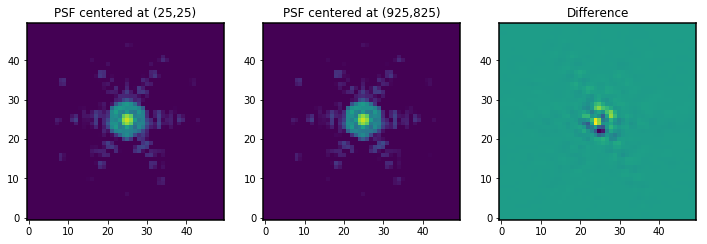

In [7]:
# Let's get a PSF near the corner of the detector
y, x = np.mgrid[0:50, 0:50]
psf = nis_grid.evaluate(x=x, y=y, flux=1, x_0=25, y_0=25)

# And closer to the center
y, x = np.mgrid[800:850, 900:950]
psf2 = nis_grid.evaluate(x=x, y=y, flux=1, x_0=925, y_0=825)

# Display them and their subtle differences
fig, ax = plt.subplots(ncols=3, figsize=(12,6))
ax[0].imshow(psf, norm=matplotlib.colors.LogNorm(vmax=0.01, vmin=1e-5))
ax[0].set_title("PSF centered at (25,25)")
ax[1].imshow(psf2, norm=matplotlib.colors.LogNorm(vmax=0.01, vmin=1e-5))
ax[1].set_title("PSF centered at (925,825)")
ax[2].imshow(psf2-psf)
ax[2].set_title("Difference")

## Example Uses of psf_grid

### Create a full grid of PSFs for 1 filter and all detectors in NIRCam

This is the same example as above.

In [ ]:
nir = webbpsf.NIRCam()
nir.filter = "F090W"
grid = nir.psf_grid()

In [ ]:
# Check out the data and meta data with
nrca1_model = grid[0]
print(nrca1_model.data)
print(nrca1_model.meta)

### Create a grid for 1 filter and 1 detector

In [ ]:
nir = webbpsf.NIRCam()
nir.filter = "F090W"
nir.detector = "NRCA2"
grid = nir.psf_grid(all_detectors=False)

### Loop through if you want multiple filters or a subset of the detectors

In [ ]:
# Loop through filters
grid_filt_list = []
nis = webbpsf.NIRISS()
for filt in nis.filter_list:
    nis.filter = filt
    grid = nis.psf_grid()
    grid_filt_list.append(grid)

# Loop through detectors
nir = webbpsf.NIRCam()
nir.filter = "F140M"
grid_det_list = []
for det in ["NRCA1", "NRCA2", "NRCA3", "NRCA4"]:
    nir.detector = det
    grid = nir.psf_grid(all_detectors=False)  
    grid_det_list.append(grid)

### Set the number of PSFs

Use the `num_psfs` keyword to set the number of PSFs in the grid. `num_psfs = 4` means you'll have a 2x2 grid. Default is 16, meaning a 4x4 grid.

In [ ]:
nis = webbpsf.NIRISS()
nis.filter = "F140M"
grid = nis.psf_grid(num_psfs=4)

### Include any `calc_psf()` **kwargs in `psf_grid()`

See the docstring of `calc_psf()` for a full description of these keyword arguments.

In [ ]:
fgs = webbpsf.FGS()
fgs.filter = "FGS"
grid = fgs.psf_grid(fov_pixels=1000, oversample=3, add_distortion=True, nlambda=30)

### Customize with other WebbPSF settings before the `psf_grid()` method call

Anything you can set in WebbPSF can be applied here. Say you want to use a different OPD, your own OPD with extra mirror moves applied to it, a pupil/image mask combination, etc:

In [ ]:
nir = webbpsf.NIRCam()
nir.filter = "F090W"

# Setting extra aspects you want applied to all the PSFs generated in the grid:
nir.pupilopd = ('OPD_RevW_ote_for_NIRCam_predicted.fits.gz', 7)
nir.pupil_mask = "WEAK LENS +4"

grid = nir.psf_grid()

### Turn off status updates with `verbose=False`

In [ ]:
mir = webbpsf.MIRI()
mir.filter = "F560W"
grid = mir.psf_grid(verbose=False)

### Saving files

In addition to returning the PSF grid, users can save the `GriddedPSFModel` objects as `FITS` files to create their own library. 

Users can set `save=True` and then can set the `outdir` and `outfile` parameters to choose the directory and name to save the file to respectively. For file location, leaving `outdir=None` will save the file in the current directory. For the file name, leaving `outfile=None` will use the default naming scheme. Otherwise, `outfile` can be set to the beginning of a file name, and then that name will then have the detector appended to it (to avoid overwritting files).

In [ ]:
nir = webbpsf.NIRCam()
nir.filter = "F090W"

# Don't save (Default)
grid = nir.psf_grid()

# Save with the default name -> {instr}_{det}_{filt}_fovp{#}_samp{#}_npsf{#}.fits in current directory
grid = nir.psf_grid(save=True, outdir=None, outfile=None, overwrite=True)

To convert the `FITS` file back to a `GriddedPSFModel` object, use `to_griddedpsfmodel()`. You can pass this either a filename or an HDUlist object.

In [ ]:
from webbpsf.utils import to_griddedpsfmodel

# As a file
grid = to_griddedpsfmodel("nircam_nrca1_f090w_fovp101_samp4_npsf16.fits")  # file created 2 cells above

# As an HDUlist object
with fits.open("nircam_nrca1_f090w_fovp101_samp4_npsf16.fits") as hdu:
    grid = to_griddedpsfmodel(hdu, ext_data=0, ext_header=0)

## Additional Options, Not Recommended for Typical Uses

<div class="alert alert-warning">
The following bits of functionality address less common use cases. Most likely you won't need them. </div>

### Detector-sampled PSF

If you want your ouput grid of PSFs to be detector sampled rather than oversampled, set `use_detsampled_psf=True`. In general we want 

In [ ]:
nir = webbpsf.NIRCam()
nir.filter = "F090W"
grid = nir.psf_grid(use_detsampled_psf=True)

### If `num_psfs=1`, set the location of the PSF with detector_position attribute

Sometimes it may be useful to have a "grid" of only 1 PSF, for instance in some software testing scenarios, or because you are simulating some cases in which you don't care about PSF field dependence. 

If `single_psf_centered = True`, then the single PSF will be at the center of the detector. If it's `False`, then the location of the PSF is pulled from the `detector_position` instrument attribute

In [ ]:
# Option 1: Set the location as the center of the detector (Default)
nis = webbpsf.NIRISS()
nis.filter = "F140M"
grid = nis.psf_grid(num_psfs=1)

# Option 2: Choose your own location
nis = webbpsf.NIRISS()
nis.filter = "F140M"
nis.detector_position = (10,10) # (x,y)
grid = nis.psf_grid(num_psfs=1, single_psf_centered=False)